## Содержание

- **[Постановка задачи](#Постановка-задачи)**
- **[Описание данных](#Описание-данных)**
- **[Импорт библиотек и кастомные функции](#Импорт-библиотек-и-кастомные-функции)**
- **[1. Загрузка данных](#1.-Загрузка-данных)**
- **[2. Предварительный анализ](#2.-Предварительный-анализ)**
- **[3. Проверка качества сплитования. А/А тесты](#3.-Проверка-качества-сплитования.-А/А-тесты)**
- **[4. Успешен ли эксперимент в общем](#4.-Успешен-ли-эксперимент-в-общем)**
- **[5. Тип подписки](#5.-Тип-подписки)**
- **[6. Страны](#6.-Страны)**
- **[7. Возраст](#7.-Возраст)**
- **[Заключение](#Заключение)**

## Постановка задачи

Представьте, что вы работаете в крупном дейтинговом приложении. Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен AА/Б тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:
- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

* *Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

## Описание данных

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

**Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

Данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2).
Для каждой из них:

**users_*.csv** – информация о пользователях:
- uid – идентификатор пользователя
- age – возраст
- attraction_coeff –  коэффициент привлекательности (от 0 до 1000, $\frac{лайки}{просмотры}*1000$ ) 
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка
 
**transactions_*.csv** – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

## Импорт библиотек и кастомные функции

In [86]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import mannwhitneyu
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(rc = {'figure.figsize':(16,9)}, style="whitegrid")

In [87]:
def aa_test(statistic, data1, data2, n_s=500):
    """
    Функция aa_test возвращает количество ложноположительных случаев 
    (проверяет, что количество ложноположительных случаев не превышает альфа)
    
    Параметры:
    - использумый статистический оценщик
    - числовые значения первой выборки
    - числовые значения второй выборки"""
    simulations = 10000
    res = []
    if n_s > min([len(data1), len(data2)]):
        n_s = min([len(data1), len(data2)])

    for i in range(simulations):
        s1 = data1.sample(n_s, replace=False).values
        s2 = data2.sample(n_s, replace=False).values
        res.append(statistic(s1, s2)[1])  # сохраняем pvalue

    return sum(np.array(res) < 0.05) / simulations

In [88]:
def correct_date(df):
    '''Принимает дафрейм, меняет его, если дата совершения покупки меньше даты регистрации'''
    wrong_date_test = df.query('paid_at < joined_at')
    correct_date_test = df.query('paid_at > joined_at')
    wrong_date_test['paid_at'] = wrong_date_test['paid_at'].apply(lambda x: datetime.strftime(x, '%Y-%d-%m %H:%M:%S'))
    wrong_date_test['paid_at'] = pd.to_datetime(wrong_date_test['paid_at'])
    df = pd.concat([wrong_date_test, correct_date_test])
    return df

In [89]:
def process_data(df):
    '''Принимает дафрейм, заменяет пропущенные значения на 0, меняет типы колонок'''
    if 'revenue' in df.columns:
        df = df.astype({'country': 'string', \
                        'from_page': 'string', \
                        'product_type': 'string',
                        'payment_id' : 'int', \
                        'uid': 'int',
                        'revenue': 'int'})
        df = df.drop_duplicates()
    else:
        df.fillna({'was_premium': 0, 'is_premium': 0, 'coins': 0}, inplace=True)
        df = df.astype({'coins': 'int', \
                        'country': 'string', \
                        'visit_days': 'string', \
                        'was_premium': 'int', \
                        'is_premium': 'int'
                       })
        df = df.drop_duplicates()
    return df

In [90]:
def change_age(df):
    '''Принимает дафрейм, заменяет возраст пользователя, который указал очень большой возраст,
       на среднее между мин. значением и макс. значением фильтра поиска данного пользователя'''
    df.loc[(df.age > 85), 'age'] = (df.age_filter_start + df.age_filter_end) // 2
    return df

## 1. Загрузка данных

In [91]:
# Пользователи
users_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/L8HxRYDn2l4h9A', sep=';')
users_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/TxOD_JxnkMd4mA', sep=';')
users_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/YT6OWRK2cTWfLg', sep=';')

In [92]:
# Транзакции
transactions_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3viYBnm7cyihkQ', sep=';', \
                               parse_dates=['paid_at', 'joined_at'])
transactions_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84jzzJeQ4tqVyg', sep=';', \
                               parse_dates=['paid_at', 'joined_at'])
transactions_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/_pOo7mrDCZZMyA', sep=';', \
                               parse_dates=['paid_at', 'joined_at'])

## 2. Предварительный анализ

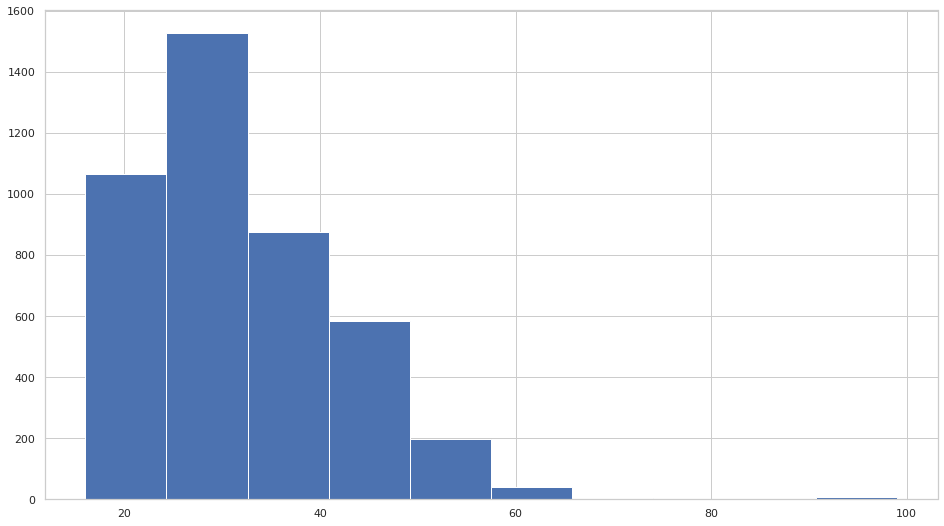

In [93]:
users_test.age.hist()

Можно заметить, что есть небольшое количество пользователей, которые скорее всего указали не свой возраст, применим к ним функция change_age

In [94]:
# Правим даты
transactions_test = correct_date(transactions_test)

In [95]:
transactions_control_1 = correct_date(transactions_control_1)

In [96]:
transactions_control_2 = correct_date(transactions_control_2)

In [97]:
# Проводим преодобработку данных
users_test = process_data(change_age(users_test))

In [98]:
users_control_1 = process_data(change_age(users_control_1))

In [99]:
users_control_2 = process_data(change_age(users_control_2))

In [100]:
transactions_test = process_data(transactions_test)

In [101]:
transactions_control_1 = process_data(transactions_control_1)

In [102]:
transactions_control_2 = process_data(transactions_control_2)

Для удобства объединим в один датасет все таблицы с пользователями, но перед этим добавим колонку с меткой, к какой группе относится пользователь

In [103]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users_full = pd.concat([users_test, users_control_1, users_control_2])

Тоже самое сделаем для таблиц с оплатами

In [104]:
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'
transactions_full = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [105]:
# Узнаем в какой период проводилось тестирование

print( ' Дата первой транзакции в тестовой группе:', transactions_test['paid_at'].min(),'\n', \
       'Дата последней транзакции в тестовой группе:', transactions_test['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 1:', transactions_control_1['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 1:', transactions_control_1['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 2:', transactions_control_2['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 2:', transactions_control_2['paid_at'].max())

 Дата первой транзакции в тестовой группе: 2017-02-11 13:43:00 
 Дата последней транзакции в тестовой группе: 2017-12-11 22:06:00

 Дата первой транзакции в контр. группе 1: 2016-12-14 16:16:00 
 Дата последней транзакции в контр. группе 1: 2017-12-11 21:57:00

 Дата первой транзакции в контр. группе 2: 2017-02-11 21:52:00 
 Дата последней транзакции в контр. группе 2: 2017-12-11 23:28:00


Видим, что в первой контрольной группе есть пользователь, совершивший оплату раньше, чем остальные, посмотрим на него внимательно.

In [106]:
transactions_control_1.query('paid_at < 2017')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type,control_1
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type,control_1
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type,control_1


Удалим его из датафрейма

In [107]:
transactions_control_1 = transactions_control_1.query('uid != 960936960')

In [108]:
# Узнаем в какой период проводилось тестирование после чистки данных

print( ' Дата первой транзакции в тестовой группе:', transactions_test['paid_at'].min(),'\n', \
       'Дата последней транзакции в тестовой группе:', transactions_test['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 1:', transactions_control_1['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 1:', transactions_control_1['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 2:', transactions_control_2['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 2:', transactions_control_2['paid_at'].max())

 Дата первой транзакции в тестовой группе: 2017-02-11 13:43:00 
 Дата последней транзакции в тестовой группе: 2017-12-11 22:06:00

 Дата первой транзакции в контр. группе 1: 2017-01-11 05:16:00 
 Дата последней транзакции в контр. группе 1: 2017-12-11 21:57:00

 Дата первой транзакции в контр. группе 2: 2017-02-11 21:52:00 
 Дата последней транзакции в контр. группе 2: 2017-12-11 23:28:00


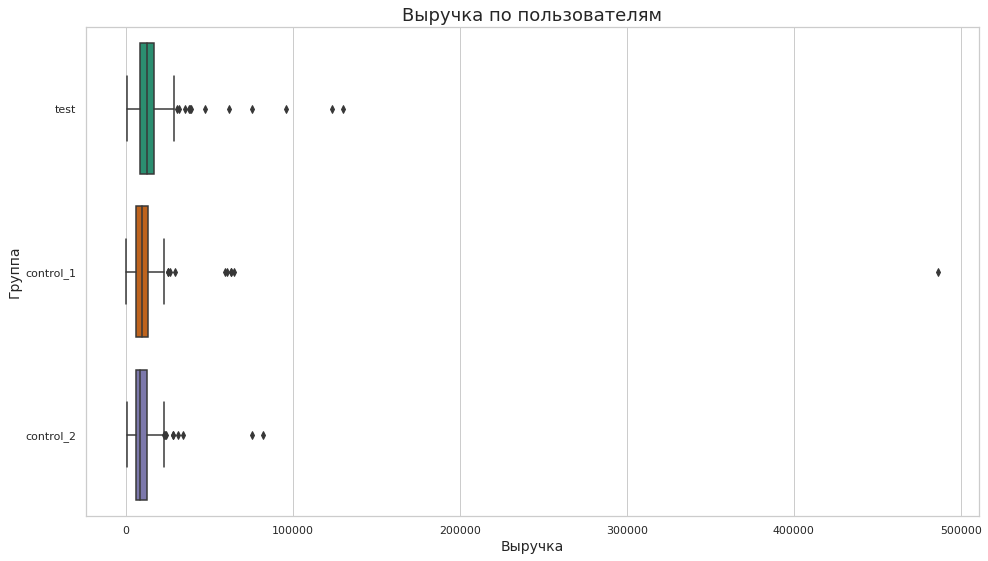

In [109]:
 # Построим боксплоты по выручке
ax = sns.boxplot(data=users_full.query('total_revenue > 0'), x='total_revenue', y='group', palette='Dark2')
ax.axes.set_title("Выручка по пользователям", fontsize=18)
ax.set_xlabel("Выручка", fontsize=14)
ax.set_ylabel("Группа", fontsize=14)
plt.show()

Как видно на графиках, в обеих выборках (control_1 и control_2) присутствуют выбросы, в особенности в первой выборке, где максимальное значение total_revenue составило почти 500.000, данный вопрос требует более детального изучения

Исследуем дополнительно наш выброс

In [110]:
users_control_1.query('total_revenue > 400000')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
1427,892333905,22,175,3608,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1,1,486330,control_1


In [111]:
transactions_control_1.query('uid == 892333905').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
49,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783,67,menu,other_type,control_1
13,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783,67,menu,other_type,control_1
28,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783,67,empty_admins,other_type,control_1
43,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783,67,empty_admins,other_type,control_1
6,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610,19,gifts,coins,control_1
137,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,31525,19,gifts,coins,control_1
289,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,3783,67,gifts,other_type,control_1
149,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,1261,19,gifts,coins,control_1
297,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525,19,menu,coins,control_1
316,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:52:00,31525,19,menu,coins,control_1


In [112]:
users_control_1.total_revenue.max() / users_control_1.total_revenue.sum()

0.1884074758635972

Видим, что в данных есть "странный" пользователь из Италии (скорее всего какой-то аферист из тиндера), сумма его покупок составляет 19 % от общей суммы, возьму на себя ответственность дропнуть данного персонажа.

In [113]:
transactions_control_1 = transactions_control_1.query('uid != 892333905')

In [114]:
users_control_1 = users_control_1.query('uid != 892333905')

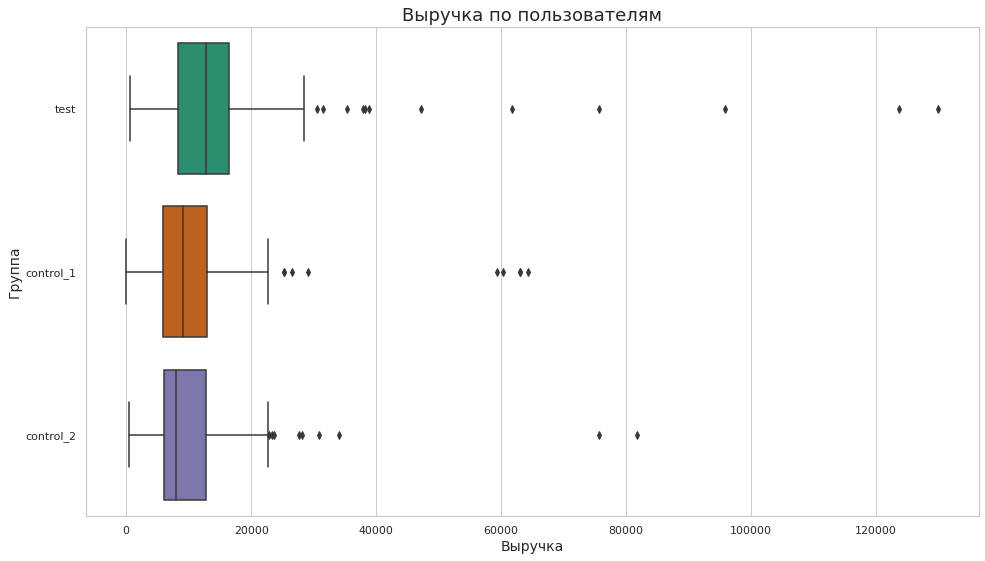

In [115]:
# Построим боксплоты по выручке без выброса
users_full = pd.concat([users_test, users_control_1, users_control_2])
ax = sns.boxplot(data=users_full.query('total_revenue > 0'), x='total_revenue', y='group', palette='Dark2')
ax.axes.set_title("Выручка по пользователям", fontsize=18)
ax.set_xlabel("Выручка", fontsize=14)
ax.set_ylabel("Группа", fontsize=14)
plt.show()

Проверим распределение total_revenue на нормальность. Н0 для теста Шапиро-Уилка : нормальность распределения

In [116]:
stats.shapiro(users_control_1.total_revenue)

ShapiroResult(statistic=0.14440131187438965, pvalue=0.0)

In [117]:
stats.shapiro(users_control_2.total_revenue)

ShapiroResult(statistic=0.1445736289024353, pvalue=0.0)

In [118]:
stats.shapiro(transactions_control_1.revenue)

ShapiroResult(statistic=0.5829354524612427, pvalue=1.5151389094921548e-27)

In [119]:
stats.shapiro(transactions_control_2.revenue)

ShapiroResult(statistic=0.5297449231147766, pvalue=1.7662834723952801e-28)

Т.к. во всех случаях pvalue < 0.05 отклоняем нулевую гипотезу, следовательно, распределение отклоняется от нормального

## 3. Проверка качества сплитования. А/А тесты

У нас А/А/В тест с двумя контролями. Проверим качество сплитования:
- ARPU
- ARPPU

Необходимо выбрать статистичеcкий оценщик, которым может быть t-тест, критерий Манна-Уитни или бутстрап. Для t-теста необходимым условием является соблюдение требования о нормальности распределения, что в нашем случае не соблюдается, кроме того, все еще присутствуют выбросы. Таким образом, можно использовать критерий Манна-Уитни или бутстрап. Воспользуемся критерием Манна-Уитни. Н0 для критерия Манна-Уитни:  равенство распределений в двух группах (случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки).

In [120]:
aa_test(mannwhitneyu, users_control_1.total_revenue, users_control_2.total_revenue)

0.0364

In [121]:
aa_test(mannwhitneyu, users_control_1.query('total_revenue > 0').total_revenue, \
                      users_control_2.query('total_revenue > 0').total_revenue)

0.0

In [122]:
aa_test(mannwhitneyu, transactions_control_1.revenue, transactions_control_2.revenue)

0.0

Тесты не выявили статистически значимых различий в значении показателя total_revenue для conrol_1 и conrol_2, полагаем, что система сплитования работает корректно, следовательно, можно объединить две контрольных группы.

In [123]:
users_full['group'] = users_full['group'].apply(lambda x: 'test' if x == 'test' else 'control')

In [124]:
transactions_full['group'] = transactions_full['group'].apply(lambda x: 'test' if x == 'test' else 'control')

Посмотрим как распределены пропорции по выборкам

In [125]:
users_test.describe()[['age', 'gender', 'is_premium', 'total_revenue']][:2]

,age,gender,is_premium,total_revenue
count,4308.000000,4308.00000,4308.000000,4308.000000
mean,31.777855,0.95311,0.036444,534.080316


In [126]:
users_control_1.describe()[['age', 'gender', 'is_premium', 'total_revenue']][:2]

,age,gender,is_premium,total_revenue
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,32.008988,0.958055,0.044019,482.815626


In [127]:
users_control_2.describe()[['age', 'gender', 'is_premium', 'total_revenue']][:2]

,age,gender,is_premium,total_revenue
count,4264.000000,4264.000000,4264.000000,4264.000000
mean,31.983583,0.954268,0.044794,450.384146


Таким образом, анализ качества сплитования позволяет сделать вывод, что в исследуемых выборках соблюдаются пропорции в разрезе по ряду характеристик. Исключив из контрольной группы выбросы и проведя по ним А/А-тест, получаем p-value < 0.05, а значит, нет оснований отвергать нулевую гипотезу Н0. Значит контрольные группы для А/B-теста были сплитованы корректно.**

##  4. Успешен ли эксперимент в общем

In [128]:
# Посчитаем метрики для тестовой и объединённой контрольной группы
metrics = pd.DataFrame({'ARPU': round(users_full.groupby('group').total_revenue.mean(), 2),
                        'ARPPU': round(users_full.query('total_revenue > 0').groupby('group').total_revenue.mean(), 2),
                        'CR': round(users_full.query('total_revenue > 0').groupby('group').uid.nunique() / \
                                    users_full.groupby('group').uid.nunique(), 3)
                        }).reset_index ()
metrics

,group,ARPU,ARPPU,CR
0,control,466.74,10622.69,0.044
1,test,534.08,15759.03,0.034


Как видно из результатов эксперимента средняя выручка на одного пользователя и средняя выручка на одного платящего пользователя в тестовой группе увеличилась, конверсия немного упала, проведем анализ для определенных групп.

##  5. Тип подписки

In [129]:
product_type = transactions_full.groupby(['group', 'product_type'], as_index=False) \
                                .agg({'revenue': 'sum', 'uid': 'count',}) \
                                .rename(columns={'uid': 'transactions'})

In [130]:
product_type['ARPU'] = round((product_type['revenue'] / product_type['transactions']), 2)

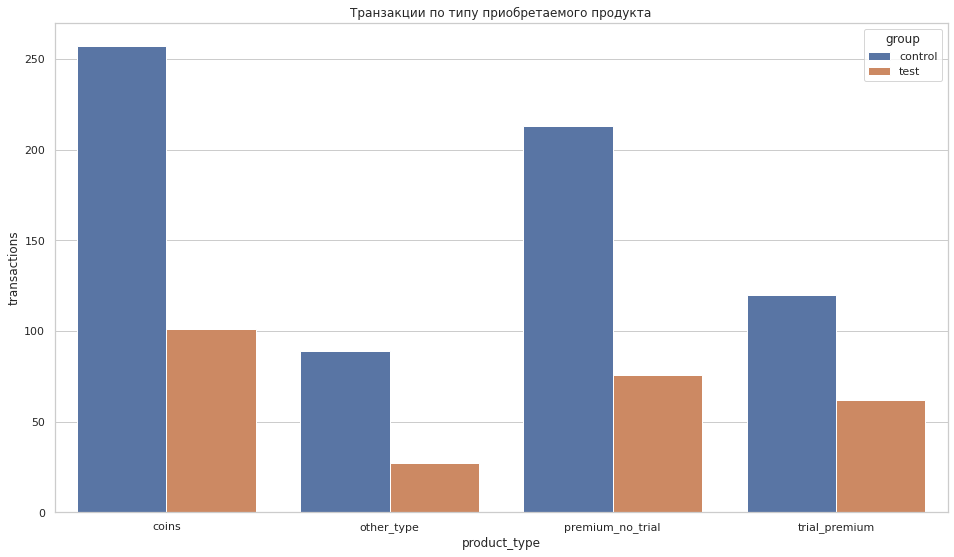

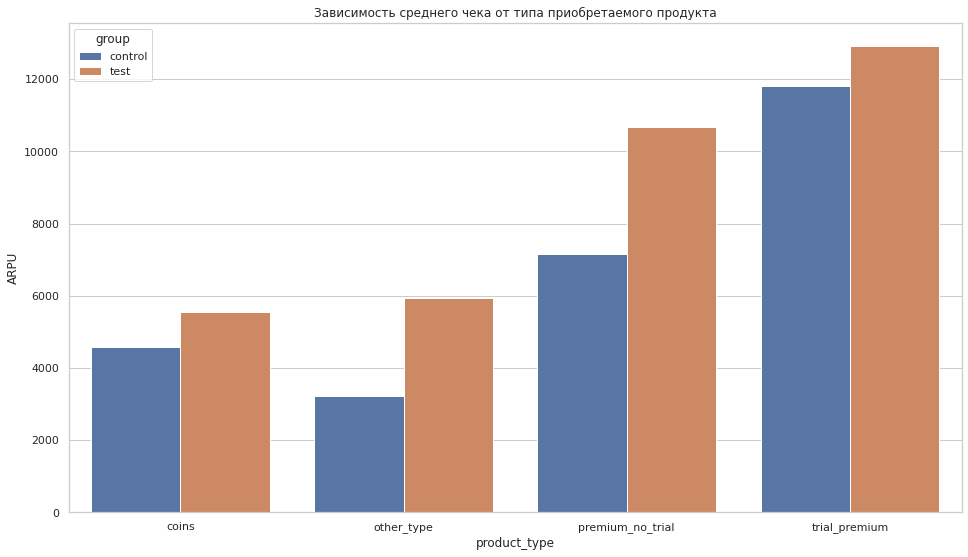

In [131]:
 # Строим барплоты:
plt.title("Транзакции по типу приобретаемого продукта")
sns.barplot(x="product_type", y="transactions", hue="group", data=product_type)
plt.show()

plt.title("Зависимость среднего чека от типа приобретаемого продукта")
sns.barplot(x="product_type", y="ARPU", hue="group", data=product_type)
plt.show()

По верхнему графику видно, что количество транзакций снизилось по каждому типу продукту, зато, средний чек вырос в каждом типе продукта.

## 6. Страны

In [132]:
arrpu_country = transactions_full.groupby(['country', 'group'], as_index = False) \
                                 .agg({'revenue':'sum', 'payment_id':'count'}) \
                                 .rename(columns={'payment_id':'transactions'}) \
                                 .sort_values('country') \
                                 .reset_index()

In [133]:
# Вычислим средний чек платящих пользователей у каждой страны:
arrpu_country['ARPPU'] = (arrpu_country['revenue']/arrpu_country['transactions']).round(2) 

In [134]:
arrpu_country = arrpu_country.pivot(index='country', columns='group', values='ARPPU') \
                             .reset_index() \
                             .dropna(subset=['test', 'control'])

In [135]:
# Посмотрим прирост для каждой страны
arrpu_country['growth_arrpu'] = round(arrpu_country.test*100/arrpu_country.control - 100, 1)

In [136]:
arrpu_country = arrpu_country.sort_values('growth_arrpu', ascending=False) \
                             .rename(columns={'control':'control_ARPPU', 'test':'test_ARPPU'})

In [137]:
arpu_country = users_full.groupby(['country', 'group'], as_index=False) \
                         .agg({'total_revenue': 'mean'}) \
                         .round(2) \
                         .query('total_revenue > 0') \
                         .rename(columns={'total_revenue': 'ARPU'}) \
                         .pivot(index='country', columns='group', values='ARPU') \
                         .rename(columns={'control':'control_ARPU', 'test':'test_ARPU'}) \
                         .reset_index() \
                         .dropna(subset=['test_ARPU', 'control_ARPU'])

In [138]:
arpu_country['growth_arpu'] = round(arpu_country.test_ARPU*100/arpu_country.control_ARPU - 100, 1)

In [139]:
country_metric = arrpu_country.merge(arpu_country)

In [140]:
country_metric

group,country,control_ARPPU,test_ARPPU,growth_arrpu,control_ARPU,test_ARPU,growth_arpu
0,Argentina,5876.58,18801.90,219.9,338.05,474.80,40.5
1,Australia,6825.00,12597.00,84.6,405.45,203.18,-49.9
2,Germany,6814.79,12012.00,76.3,244.63,459.79,88.0
3,United Arab Emirates,10704.78,17815.42,66.4,460.97,945.95,105.2
4,France,5515.03,8755.88,58.8,446.95,706.45,58.1
5,Spain,7508.67,11417.12,52.1,449.14,948.27,111.1
6,Israel,4556.82,6682.00,46.6,1001.70,894.42,-10.7
7,United States of America,6363.72,7992.81,25.6,438.92,497.82,13.4
8,Belgium,8658.00,10447.67,20.7,787.09,681.37,-13.4
9,United Kingdom (Great Britain),5908.76,6448.00,9.1,1011.77,457.85,-54.7


Из данной таблицы видно, что эксперимент получился совсем неудачным для Turkey, Switzerland, Italy, Chile. Удачным для Argentina, Germany, United Arab Emirates, France, Spain, United States of America.

## 7. Возраст

In [141]:
users_full.query('age > 85')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
2312,891682545,99,0,0,United States of America,<NA>,1,96,102,0,0,0,0,control


Видим, что есть пользователь, которому 99 лет, и который ищет себе пару в возрасте от 96 до 102, пожертвуем этим казановой

In [142]:
users_full = users_full.query('age < 85')

In [143]:
# Сгруппируем датафрейм по возрасту
users_full['age_category'] = pd.cut(users_full['age'],
                                    bins=[16,30,40,50,100],
                                    labels=['16-29','30-40','40-50','50+'])

In [144]:
# Посчитаем ARPU по тестовым и возрастным группам
# pivot_table по умолчанию агрегирует по среднему
ARPU_age = users_full.pivot_table(index='age_category',
                                  columns='group',
                                  values='total_revenue') \
                                 .rename_axis(None).round(2)

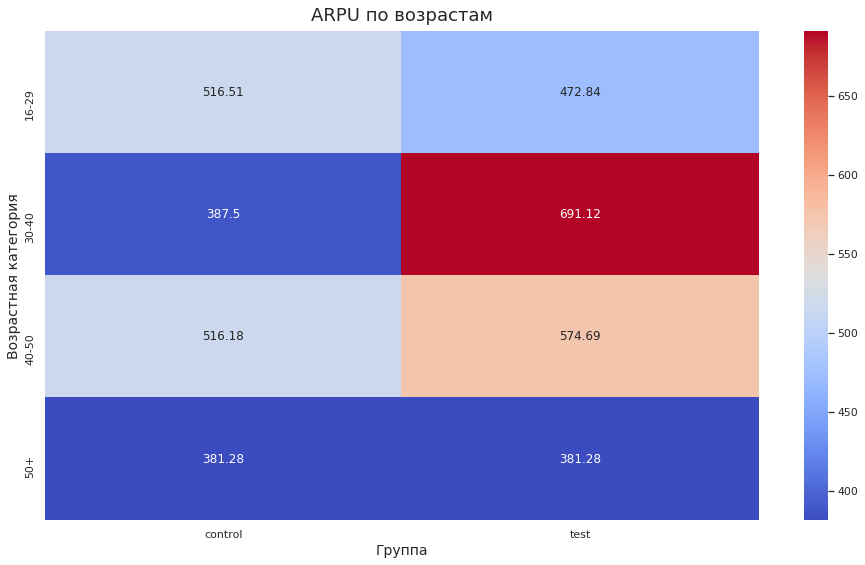

In [145]:
'''для наглядности построим heatmap'''
ax = sns.heatmap(ARPU_age, cmap='coolwarm',
                 annot=True,
                 fmt='')
ax.axes.set_title('ARPU по возрастам', fontsize=18, pad=10)
ax.set_xlabel("Группа", fontsize=14)
ax.set_ylabel("Возрастная категория", fontsize=14)
plt.show()

Средний чек понизился у пользоветелей 16-29, самый большой прирост среднего чека у категории 30-40.

# Заключение
- Было проведено А/А/В-тестирование, при сравнении показателей ARPU, ARPPU по контрольным группам статистически значимых различий выявлено не было, вследствие чего контрольные группы были объединены. Был применен для оценки статистической значимости непараметрический критерий Манна Уитни посколько распределение не является нормальным и присутствуют значительные выбросы. 

- В целом эксперимент нельзя назвать слишком успешным, при сравнении по группам, мы увидили что для некоторых стран и определенных возрастов эксперимент прошел удачно (Argentina, Germany, United Arab Emirates, France, Spain, United States of America) для других стран мы видим, что ARPPU и ARPU снизился. В тестовой группе в целом у нас увеличилсь ARPU и ARPPU, зато уменьшилась конверсия, число транзакций стало меньше.